# Load Profile Estimation
## Introduction
A notebook to visualize load profile estimation of a building from the NREL ComStock dataset. The building chosen is an outpatient facility in the ASHRAE 1A climate zone (hot, humid).  This notebook demonstrates how freature engineering can be used to predict electricity load profiles for a building throughout a year.

## Problem Statement
**Can machine learning be leveraged to accurately estimate a yearly electrical load profile for building?**

### Notes
The ML model deployed here is an out-of-the-box XGBoost model. This notebook focuses on timeseries feature engineering and thus no parameter tuning has been done on the model.

### Imports
The following Python libraries are used: 
 * `pandas` for tabular/matrix representation of the timeseries
 * `numpy` for linear algebra
 * `xgboost` the ML model
 * `sklearn` for subsetting the data into train & test sets
 * `matplotlib` for viz

The following notebook has dependencies:
 * `pyarrow` or `fastparquet` for reading the NREL data into `pandas`
 * `scipy` for performing Fast Fourier Transforms

In [1]:
# library imports
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# custom function imports
from utils import get_peak_frequencies, engineer_features

## Preprocessing
The goal of this notebook is preprocessing and feature engineering. Some utility functions have been created and can be found int `utils.py` in the root folder:
 * `get_peak_frequencies` returns an array of the frequencies seen in the data
 * `engineer_features` adds columns to the dataframe based on features of interest.

## Data
Electrical load profiles typically span a year of operation for a building. The data used to train this model comes from the National Renewable Energy Laboratory (NREL) ComStock End Use Load Profile (EULP) dataset available [here](). Building data is provided in *parquet* files (which require the packages `pyarrow` or `fastparquet`) to use with `pandas`. The dataset contains 1 sample every 15 minutes for an entire year, for a total of 35,040 samples. 

The NREL data are loaded into the `bldg_22122` object and then the `load_profile` variable (desired to be predicted) is extracted. Next, we use the `peak_freqs` function to examine the load profile throughout the year. The function performs a [Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform) on the load profile signal and returns an array containing the most prominent frequencies throughout the year. The load profile and frequency array are then passed into the `engineer_features` function that returns a dataframe of engineered features.

### The Engineered Features
The features created by the engineered features are as follows:
 * **cosine** the cosine value for the number of occurences throught the year [-1,1]
 * **sine** the sine value for the number of occurences throughout the year [-1,1]
 * **day of week** the number of the day in the week {0,1,...,6}
 * **day of year** the day of the year {0,1,...,364}
 * **weekend** whether the day is a weekend {0,1}
 * **holiday** whether the day is a US Federal holiday {0,1}

*data is trained on a 365-day year, i.e., not a leap-year*.


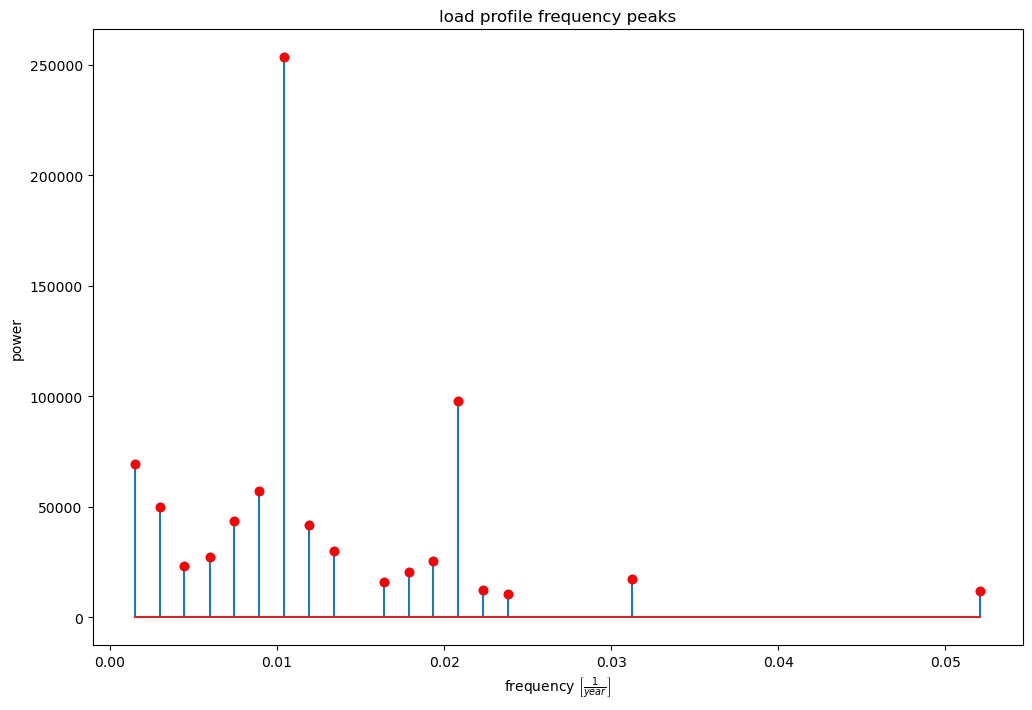

Number of rows in dataset:35040, Number of columns in dataset: 46


,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,day_of_week,day_of_year,weekend,...,cos_730_py,sin_782_py,cos_782_py,sin_834_py,cos_834_py,sin_1095_py,cos_1095_py,sin_1824_py,cos_1824_py,out.electricity.total.energy_consumption
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:15:00,0,1,0,0,0,0,0,0,1,0,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,8.267236
2018-01-01 00:30:00,0,1,0,0,0,0,0,0,1,0,...,0.999963,0.008035,0.999968,0.007534,0.999972,0.005738,0.999984,0.003443,0.999994,8.269804
2018-01-01 00:45:00,0,1,0,0,0,0,0,0,1,0,...,0.999852,0.016069,0.999871,0.015067,0.999886,0.011476,0.999934,0.006886,0.999976,8.271807
2018-01-01 01:00:00,0,1,0,0,0,0,0,0,1,0,...,0.999667,0.024102,0.999710,0.022599,0.999745,0.017213,0.999852,0.010328,0.999947,8.272570
2018-01-01 01:15:00,0,1,0,0,0,0,0,0,1,0,...,0.999407,0.032134,0.999484,0.030131,0.999546,0.022950,0.999737,0.013771,0.999905,8.266240


In [2]:
# load data into dataframe
bldg_221122 = pd.read_parquet("./data/221122-0.parquet").set_index('timestamp')
load_profile = pd.DataFrame(bldg_221122['out.electricity.total.energy_consumption'])
peak_freqs = get_peak_frequencies(load_profile, show_plot=True)
df = engineer_features(load_profile, peak_freqs)
print(f"Number of rows in dataset:{df.shape[0]}, Number of columns in dataset: {df.shape[1]}")
df.head()



The `engineer_features` function also can output a plot of the frequencies used (shown above) to calculate the sine and cosine values.

## Create Training and Testing Datasets
In order to facilitate direct comparison of model performance with increasing number of engineered features, the XGBoost model is out-of-the-box, i.e., no parameter tuning. 

The dataframe is split into two variables `X` and `y`. `X` contains all the predictors (engineered features). In the first cut, we use the most prominent frequencies (17 total) to generate sine and cosine waves in addition to the holiday, day of week, day of year, and day number features extracted from the timeseries.

Next we split the data into training and testing sets. For this analysis, we use the last quarter of the year as test data.

Next, we provide the model with an objective function (used for regression instead of classification). We also provide the model with a metric to optimize over, in this case [root mean squared error](https://en.wikipedia.org/wiki/Root-mean-square_deviation). 

After this we train (fit) the model to the training subset, and finally make predictions on the test subset.

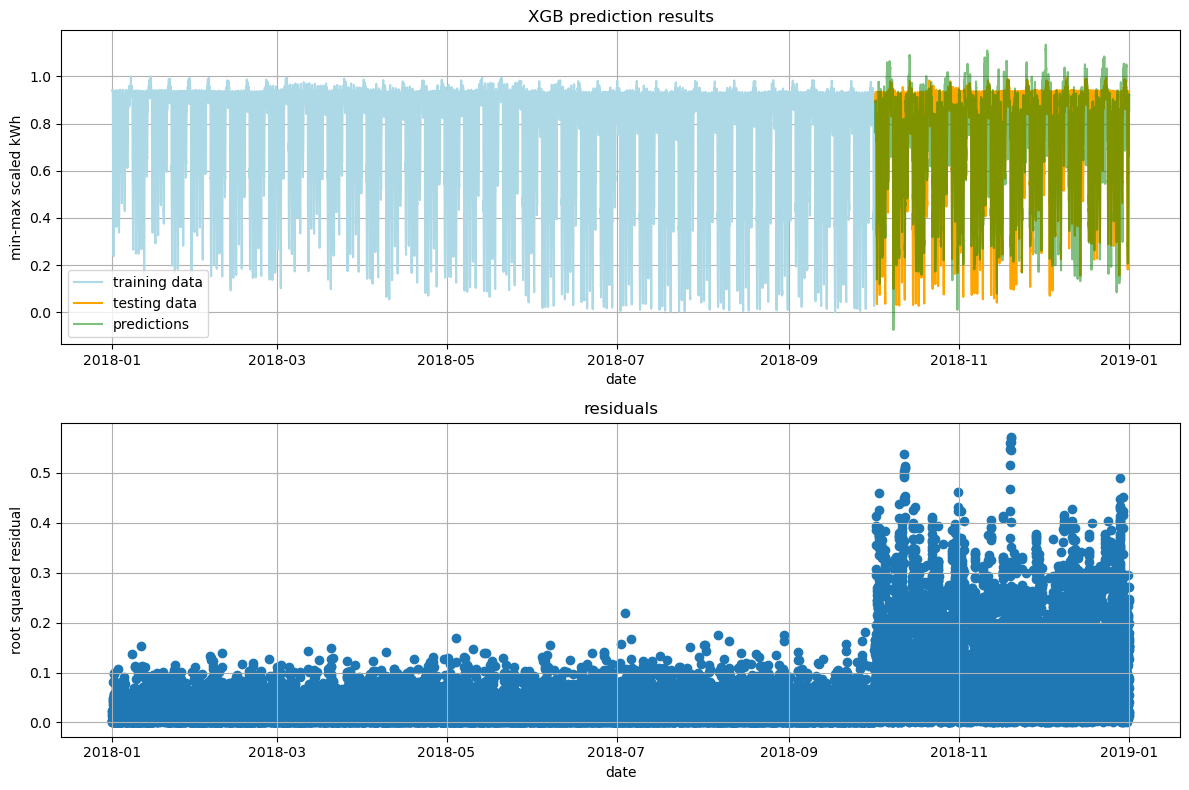

RMSE (test set): 1586.7436369717539


In [3]:
# subset data
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
y = (y.max() - y) / (y.max() - y.min())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
train_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
test_dmatrix = xgb.DMatrix(data=X_test)

# create ML model for regression with metric=rmse
reg = xgb.XGBRegressor(objective ='reg:squarederror', eval_metric='rmse')
# train model
reg.fit(X_train, y_train)

# plot results
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
preds_os = reg.predict(X_test)
preds_is = reg.predict(X_train)
preds_total = reg.predict(X)
preds = pd.DataFrame(preds_os, index=y_test.index)
ax[0].plot(y_train, color='lightblue', label='training data')
ax[0].plot(y_test, color='orange', label='testing data')
ax[0].plot(preds, color='green', alpha = 0.5, label='predictions')
ax[0].set_title('XGB prediction results')
ax[0].set_xlabel('date')
ax[0].set_ylabel('min-max scaled kWh')
ax[0].legend()
ax[0].grid()
root_squared_residuals = np.sqrt((preds_total - y)**2)
ax[1].scatter(y.index, root_squared_residuals, label = "root squared residuals")
ax[1].set_title('residuals')
ax[1].set_xlabel('date')
ax[1].set_ylabel('root squared residual')
ax[1].grid()
plt.tight_layout()
plt.show()
# show metric
print(f"RMSE (test set): {np.sum(root_squared_residuals)}")



As shown in the above plot, the model does pretty well our engineered features. However, there still appears to be some periodic behavior that is not appropriately dealt with in the base model. Our initial model has an RMSE of ~1600. We will refer to the RMSE going forward for how well the model fits the data. 

We will address this by adding more information to training our model. The NREL dataset also includes weather data for each county. The weather data adds the following features:
 * Dry bulb temperature
 * Relative Humidity
 * Wind Speed
 * Wind Direction
 * Global Horizontal Radiation
 * Direct Normal Radiation
 * Diffuse Horizontal Radiation

After adding these features, we retrain the model and re-evaluate the results

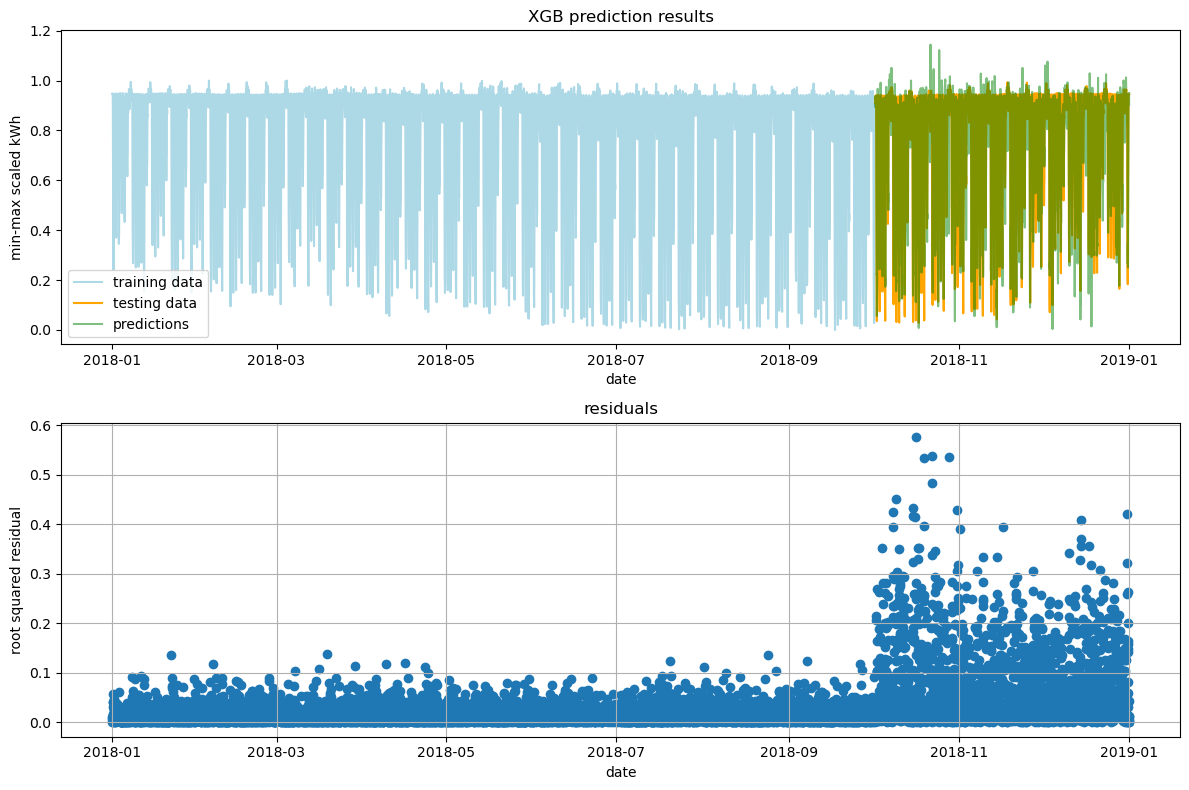

RMSE (test set): 267.49065487681287


In [4]:
# add weather to dataframe
weather = pd.read_csv('data/G1200860_2018.csv', parse_dates=[0])
weather = weather.rename(columns={'date_time':'timestamp'}).set_index('timestamp')
df2 = weather.join(df, how='left')

# subset data into training and test sets
X = df2.iloc[:,:-1]
y = df2.iloc[:,-1]
y = (y.max() - y) / (y.max() - y.min())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

#import and train model as before
reg = xgb.XGBRegressor(objective ='reg:squarederror', eval_metric='rmse')
reg.fit(X_train.values, y_train.values)

# plot results
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
preds_os = reg.predict(X_test)
preds_is = reg.predict(X_train)
preds_total = reg.predict(X)
preds = pd.DataFrame(preds_os, index=y_test.index)
ax[0].plot(y_train, color='lightblue', label='training data')
ax[0].plot(y_test, color='orange', label='testing data')
ax[0].plot(preds, color='green', alpha = 0.5, label='predictions')
ax[0].set_title('XGB prediction results')
ax[0].set_xlabel('date')
ax[0].set_ylabel('min-max scaled kWh')
ax[0].legend()
root_squared_residuals = np.sqrt((preds_total - y)**2)
ax[1].scatter(y.index, root_squared_residuals, label = "root squared residuals")
ax[1].set_title('residuals')
ax[1].set_xlabel('date')
ax[1].set_ylabel('root squared residual')
ax[1].grid()
plt.tight_layout()
plt.show()
# show metric
print(f"RMSE (test set): {np.sum(root_squared_residuals)}")



We can see that the model has improved significantly. By adding the weather data, we have improved our error metric by a factor of 6.

However, we can still see some problems in periodicity. We will address this by increasing the number of frequencies we pass to our model. We do this by lowering the threshold of the frequencies by passing `peak_prominence` as an option to our `peak_freqs` function). The default peak_promenince threshold is $10^4$, but we will change this to $10^3$.

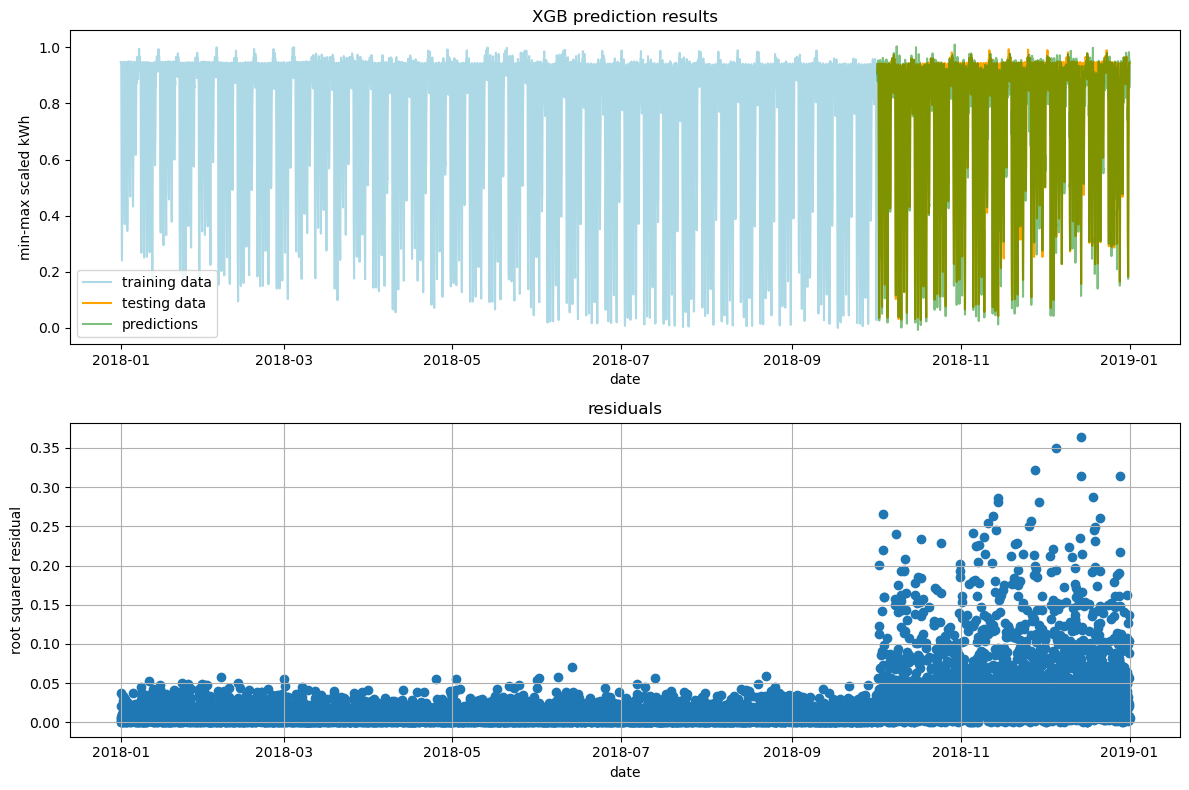

RMSE (test set): 164.03276572702


In [5]:
bldg_221122 = pd.read_parquet("./data/221122-0.parquet").set_index('timestamp')
load_profile = pd.DataFrame(bldg_221122['out.electricity.total.energy_consumption'])
peak_freqs = get_peak_frequencies(load_profile, peak_prominence=10**3, show_plot=False)
df = engineer_features(load_profile, peak_freqs)
weather = pd.read_csv('data/G1200860_2018.csv', parse_dates=[0])
weather = weather.rename(columns={'date_time':'timestamp'}).set_index('timestamp')
df2 = weather.join(df, how='left')
X = df2.iloc[:,:-1]
y = df2.iloc[:,-1]
y = (y.max() - y) / (y.max() - y.min())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
reg = xgb.XGBRegressor(objective ='reg:squarederror', eval_metric='rmse')
reg.fit(X_train.values, y_train.values)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
preds_os = reg.predict(X_test)
preds_is = reg.predict(X_train)
preds_total = reg.predict(X)
preds = pd.DataFrame(preds_os, index=y_test.index)
ax[0].plot(y_train, color='lightblue', label='training data')
ax[0].plot(y_test, color='orange', label='testing data')
ax[0].plot(preds, color='green', alpha = 0.5, label='predictions')
ax[0].set_title('XGB prediction results')
ax[0].set_xlabel('date')
ax[0].set_ylabel('min-max scaled kWh')
ax[0].legend()
root_squared_residuals = np.sqrt((preds_total - y)**2)
ax[1].scatter(y.index, root_squared_residuals, label = "root squared residuals")
ax[1].set_title('residuals')
ax[1].set_xlabel('date')
ax[1].set_ylabel('root squared residual')
ax[1].grid()
plt.tight_layout()
plt.show()
# show metric
print(f"RMSE (test set): {np.sum(root_squared_residuals)}")

In this new dataset we are now providing sine and cosine values for ~200 frequencies as features. And the metrics indicate that the model has improved by a factor of 10 from the original model. It is also apparent from visual inspection of the predictions that the model trained on the final dataset does a much better job of capturing the periodicities evident in the dataset. 

## Future Work
